# Bitcoin Price Prediction

##### Feito por: Henrique, Omar, Nevton

### Introdução
#### As criptomoedas estão cada vez mais ganhando espaço no mercado financeiro. Muitos dizem que as criptomoedas não passam de uma bolha especulativa, porém mesmo após uma forte queda a partir de 2018, o preço desses ativos em geral se mantem em um patamar relevante. Devido a alta volatilidade achamos que seria interessante fazer uma análise preditiva sobre o preço dos ativos uma vez que com grande volartilidade existem maiores oportunidades para se ganhar dinheiro. Escolhemos fazer apenas com Bitcoin, pois é a primeira, maior e principal criptomoeda.  
#### Dessa forma nosso objetivo era criar um modelo para tentar prever o preço do bitcoin, para a partir disso tomar decisões de investimento. Para fazer isso, primeiramente coletamos diversas variáveis sobre a rede do Bitcoin, nos ultimos 5 anos. Essas informações podem ser achadas no link: https://www.blockchain.com/charts. E relacionamos essas variáveis com nossa variável chave que era market_price2 (preço em dólares)
#### Nossa pergunta motriz foi: Qual vai ser o preço do Bitcoin No Futuro?

#### Para responder essa pergunta fizemos um regressão multipla e também usamos um método chamado Decision Tree Regressor

In [28]:
import numpy as np
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [29]:
dfs = pd.read_excel('DataFrame_bitcoin.xlsx')
data = pd.read_csv('difficulty.csv')

### Gráfico de como o preço do bitcoin se comportou de 2014 até agora

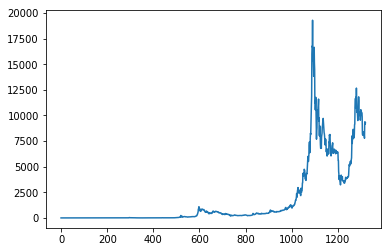

In [30]:
plt.plot(dfs['market_price_2'])

### Análise exploratória
Primeiramente foi feito uma análise exploratória dos dados. Dados que estamos cruzando variáveis quantitativas o melhor método para vizualizarmos é com um scatter plot. Por termos um número grande de variáveis, primeiro fizemos uma tabela de correlação e analisamos, através do scatter plot, apenas as variáveis que mais se correlacionavam com nossa variável de interrese: 'Market_price_2'

In [31]:
tabela_corr = dfs.corr()
tabela_corr

,avg_block_size,cost_per_transaction_percent,cost_per_transaction,difficulty,estimated_transaction_volume_usd,hash_rate,market_cap,market_price_2,miners_revenue,n_transactions_excluding_popular,n_transactions,output_volume,total_bitcoins,transaction_fees
avg_block_size,1.000000,-0.051597,0.529394,0.636240,0.661933,0.626424,0.702011,0.702377,0.665177,0.971450,0.972875,0.259226,0.853095,0.515961
cost_per_transaction_percent,-0.051597,1.000000,-0.038664,-0.023245,-0.025296,-0.023179,-0.027506,-0.028073,-0.028579,-0.048561,-0.051035,-0.033656,-0.091230,-0.025885
cost_per_transaction,0.529394,-0.038664,1.000000,0.559057,0.738785,0.569977,0.857025,0.867885,0.881768,0.494602,0.500931,0.033923,0.550975,0.402727
difficulty,0.636240,-0.023245,0.559057,1.000000,0.530863,0.992881,0.786755,0.769127,0.684650,0.628557,0.637798,0.022962,0.503553,0.073641
estimated_transaction_volume_usd,0.661933,-0.025296,0.738785,0.530863,1.000000,0.531814,0.876827,0.884338,0.911858,0.661108,0.670106,0.138356,0.492783,0.682271
hash_rate,0.626424,-0.023179,0.569977,0.992881,0.531814,1.000000,0.789750,0.772287,0.698649,0.631557,0.640881,0.020669,0.502001,0.077810
market_cap,0.702011,-0.027506,0.857025,0.786755,0.876827,0.789750,1.000000,0.999379,0.976817,0.683876,0.693548,0.082127,0.556133,0.472432
market_price_2,0.702377,-0.028073,0.867885,0.769127,0.884338,0.772287,0.999379,1.000000,0.980881,0.683373,0.692805,0.084028,0.560533,0.487465
miners_revenue,0.665177,-0.028579,0.881768,0.684650,0.911858,0.698649,0.976817,0.980881,1.000000,0.666400,0.676036,0.091096,0.545469,0.564392
n_transactions_excluding_popular,0.971450,-0.048561,0.494602,0.628557,0.661108,0.631557,0.683876,0.683373,0.666400,1.000000,0.995444,0.259574,0.823252,0.540150


### Como podemos ver as variáveis que apresentam a correlação mais forte com o market price (preço) são:  
-miners_revenue  
-Dificuldade  
-Hash_rate<br>
-Market_Cap<br>
-Volume Estimado Da Transacao<br>
#### Agora vamos analisar mais a fundo essas relações

Text(0, 0.5, 'remuneração dos mineradores')

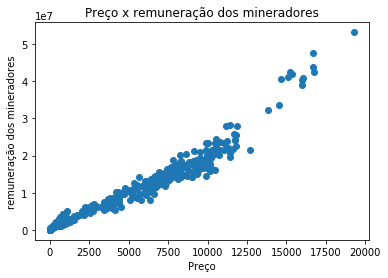

In [32]:
plt.scatter(dfs["market_price_2"],dfs["miners_revenue"])
plt.title('Preço x remuneração dos mineradores')
plt.xlabel('Preço')
plt.ylabel('remuneração dos mineradores')

Notasse uma forte correlação positiva

Text(0, 0.5, 'Dificuladade')

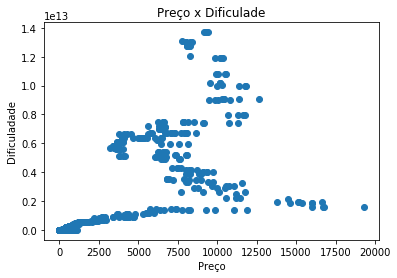

In [33]:
plt.scatter(dfs["market_price_2"],dfs["difficulty"])
plt.title('Preço x Dificulade')
plt.xlabel('Preço')
plt.ylabel('Dificuladade')

Podemos ver que quanto mais difícil é para minerar um bloco maior o preço

Text(0, 0.5, 'Hash Rate')

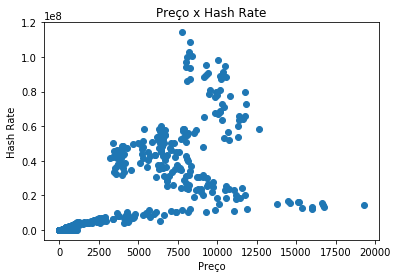

In [34]:
plt.scatter(dfs["market_price_2"],dfs["hash_rate"])
plt.title('Preço x Hash Rate')
plt.xlabel('Preço')
plt.ylabel('Hash Rate')

A relação é muito parecida com a descrita a cima. Ao fazer uma análise mais profunda sobre os conceitos intrincecos dessas duas variáveis, percebe-se que no fundo o hash rate e a dificuldade são quase a mesma coisa.  
Pode-se encontrar mais informações sobre esses conceitos em : https://2miners.com/blog/mining-difficulty-and-network-hashrate-explained/

Text(0, 0.5, 'Market_Cap')

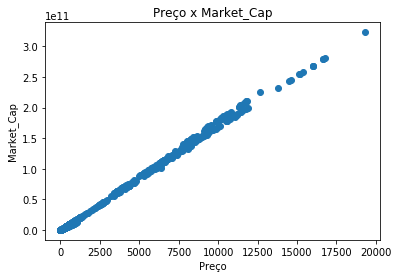

In [35]:
plt.scatter(dfs["market_price_2"],dfs["market_cap"])
plt.title('Preço x Market_Cap')
plt.xlabel('Preço')
plt.ylabel('Market_Cap')

O market cap se mostrou muito relacionado com o preço, porém ao analisar o que a variável significa, concluimos que o market cap é um desdobramento do preço. Formula para se achar o market cap = Preço * quantidade de moedas em circulação. Por isso vamos excluir essa variável para fazer as regressões

Text(0, 0.5, 'Volumne Estimado Da Transacao')

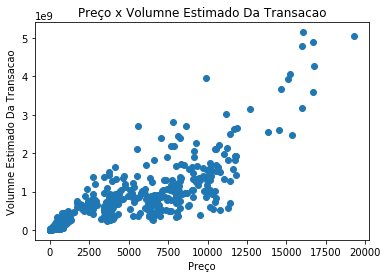

In [36]:
plt.scatter(dfs["market_price_2"],dfs["estimated_transaction_volume_usd"])
plt.title('Preço x Volumne Estimado Da Transacao')
plt.xlabel('Preço')
plt.ylabel('Volumne Estimado Da Transacao')

Podemos observar uma correlacão forte positiva, ou seja, quanto maior o volume de transações maior o preço. Isso nos indica que se a rede esta mais ativa, mais pessoas querendo transacionar, o preco tende a aumentar

In [37]:
df_treinamento = dfs.iloc[550:991]
df_teste = dfs.iloc[991:]

In [38]:
Y_treinamento = df_treinamento['market_price_2']
X_treinamento = df_treinamento[[
 'avg_block_size',
 'cost_per_transaction',
 'difficulty',
 'estimated_transaction_volume_usd',
 'hash_rate',
 'miners_revenue',
 'n_transactions',
 'transaction_fees'
]]
Y_teste = df_teste['market_price_2']
X_teste = df_teste[[
 'avg_block_size',
 'cost_per_transaction',
 'difficulty',
 'estimated_transaction_volume_usd',
 'hash_rate',
 'miners_revenue',
 'n_transactions',
 'transaction_fees'
]]

## Fazendo a Regressão linear multipla

A regressão linear multipla é um conjunto de técnicas estatísticas a fim de construir modelos que possam descrever de maneira razoável relações entre várias variáveis explicativas de um determinado processo. Chamamos de Regressão linear multipla por usarmos varias variaveis.

Para fazer a regressão dividimos o dataframe em 2, sendo o primeiro para treinar o modelo e o segundo para verificar a acurrácia desse

In [39]:
def regress(X,Y):
    X_cp = sm.add_constant(X)
    model = sm.OLS(Y,X_cp)
    results = model.fit()
    return results

In [40]:
def rms(y,y_pred):
    return (sum((y-y_pred)**2)*1/len(y))**0.5

In [41]:
regress(X_treinamento,Y_treinamento).summary()

/Users/omarafrangeneto/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         market_price_2   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     748.6
Date:                Thu, 21 Nov 2019   Prob (F-statistic):          9.30e-248
Time:                        21:02:06   Log-Likelihood:                -2419.4
No. Observations:                 441   AIC:                             4857.
Df Residuals:                     432   BIC:                             4894.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
const                               47.7454     12.490      3.823      0.000      23.197      72.294
avg_block_size                      98.4434     51.533      1.910      0.057      -2.843     199.730
cost_per_transaction                 7.0955      0.696     10.199      0.000       5.728       8.463
difficulty                         2.18e-09      3e-10      7.268      0.000    1.59e-09    2.77e-09
estimated_transaction_volume_usd  6.816e-07   7.82e-08      8.721      0.000    5.28e-07    8.35e-07
hash_rate                         -3.73e-05   3.85e-05     -0.968      0.333      -0.000    3.84e-05
miners_revenue                    8.479e-05   1.19e-05      7.105      0.000    6.13e-05       0.000
n_transactions                      -0.0010      0.000     -4.568      0.000      -0.001      -0.001
transaction_fees                    -0.0617      0.114     -0.543      0.587      -0.285       0.162
==============================================================================
Omnibus:                       23.579   Durbin-Watson:                   0.888
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.306
Skew:                          -0.463   Prob(JB):                     2.63e-07
Kurtosis:                       3.889   Cond. No.                     2.53e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.53e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Em nossa primeira regressão obtivemos um r-squared de 93.3%, ou seja, nosso modelo se ajusta aos pontos em 93.3% dos casos.

#### Neste primeiro modelo, no entanto estamos apenas usando os dados de um dia atrás, o que torna nosso modelo muito simples e falho. Dessa forma vamos varias a janela temporal usada para verificar qual a melhor janela de tempo para se usar

In [42]:
n = len(Y_treinamento)
lista = []
dias = []
for i in range(20):
    Y_offset = Y_treinamento.values[i:]
    X_offset = X_treinamento.values[:(n-i),:]
    results = regress(X_offset,Y_offset)
    lista.append(results)
    dias.append(i)
    print(i, results.rsquared)

0 0.9327212575912583
1 0.9205333154757493
2 0.9084978141259428
3 0.881594455861121
4 0.865758215241042
5 0.8408520179047023
6 0.8216158664937734
7 0.7951816799996947
8 0.7826987783675995
9 0.766294672575538
10 0.7489807309294225
11 0.7344752780329493
12 0.7158458713185514
13 0.7052632422176477
14 0.6844160872463255
15 0.6686160320719752
16 0.6539225609975188
17 0.6398518956599751
18 0.6219755333484382
19 0.603465844518333


#### Decidimos fazer a analise usando 10 períodos anteriores, uma vez que analisando até 200 períodos esse foi com maior precisão, ainda sim usando dados anteriores

In [43]:
i = 10
Y_offset1 = Y_treinamento.values[i:]
X_offset1 = X_treinamento.values[:(n-i),:]
modelo = regress(X_offset1,Y_offset1)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.749
Model:                            OLS   Adj. R-squared:                  0.744
Method:                 Least Squares   F-statistic:                     157.4
Date:                Thu, 21 Nov 2019   Prob (F-statistic):          1.48e-121
Time:                        21:02:07   Log-Likelihood:                -2640.2
No. Observations:                 431   AIC:                             5298.
Df Residuals:                     422   BIC:                             5335.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.6904     23.897      5.594      0.000      86.718     180.663
x1          -214.1600     99.475     -2.153      0.032    -409.688     -18.632
x2            11.7205      1.337      8.764      0.000       9.092      14.349
x3          2.334e-09   6.04e-10      3.866      0.000    1.15e-09    3.52e-09
x4          7.948e-07    1.5e-07      5.308      0.000       5e-07    1.09e-06
x5         -2.935e-05   7.72e-05     -0.380      0.704      -0.000       0.000
x6         -4.368e-05   2.31e-05     -1.891      0.059   -8.91e-05    1.72e-06
x7             0.0002      0.000      0.556      0.578      -0.001       0.001
x8             0.3974      0.221      1.798      0.073      -0.037       0.832
==============================================================================
Omnibus:                      236.199   Durbin-Watson:                   0.439
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2106.770
Skew:                           2.197   Prob(JB):                         0.00
Kurtosis:                      12.900   Cond. No.                     2.30e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.3e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [66]:
X_test_c = sm.add_constant(X_teste1)
y_pred=modelo.predict(X_test_c)
print("R2  =",r2_score(Y_teste, y_pred))
print("RMS =",rms(Y_teste, y_pred))

R2  = -5.292054926196249
RMS = 8705.278322138442


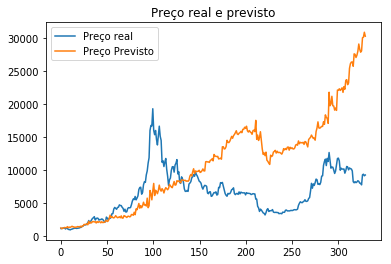

In [45]:
lista = np.linspace(0, 329, 329)
plt.title('Preço real e previsto')
plt.plot(lista,Y_teste, label='Preço real')
plt.plot(lista,y_pred, label = 'Preço Previsto')
plt.legend()

Como podemos analisar no resultado da regressão tivemos algumas variáveis com um  valor p a cima do nível de significancia (0.05). Isso nos mostra que não é possível ter certeza que essas variáveis influenciam no modelo. No entanto, as varíveis que estão dentro desse nível nos podemos confirmar que são influentes no modelo

In [46]:
X_treinamento1 = df_treinamento[[
 'avg_block_size',
 'cost_per_transaction',
 'difficulty',
 'estimated_transaction_volume_usd',
]]
X_teste1 = df_teste[[
 'avg_block_size',
 'cost_per_transaction',
 'difficulty',
 'estimated_transaction_volume_usd',
]]

In [47]:
i = 10
Y_offset1 = Y_treinamento.values[i:]
X_offset1 = X_treinamento1.values[:(n-i),:]
modelo = regress(X_offset1,Y_offset1)
modelo.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     307.9
Date:                Thu, 21 Nov 2019   Prob (F-statistic):          3.35e-124
Time:                        21:02:08   Log-Likelihood:                -2645.3
No. Observations:                 431   AIC:                             5301.
Df Residuals:                     426   BIC:                             5321.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        151.1136     21.431      7.051      0.000     108.989     193.238
x1          -221.5164     54.298     -4.080      0.000    -328.243    -114.790
x2             9.2098      0.487     18.909      0.000       8.253      10.167
x3          2.251e-09   1.34e-10     16.776      0.000    1.99e-09    2.52e-09
x4          7.263e-07   1.21e-07      5.991      0.000    4.88e-07    9.65e-07
==============================================================================
Omnibus:                      259.509   Durbin-Watson:                   0.379
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2582.217
Skew:                           2.445   Prob(JB):                         0.00
Kurtosis:                      13.949   Cond. No.                     1.31e+12
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.31e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Ao tirar as variáveis é possível perceber que não houve melhora na performace do código e por isso usaremos os modelos com mais variáveis

#### Em nossa segunda regressão obtivemos um r-squared de 74.3%, ou seja, nosso modelo se ajusta aos pontos em 74.3% dos casos.

## Fazendo o  Decision Tree Regressor

Uma árvore de decisão é um modelo de machine learning supervisionada, usado para prever um destino, aprendendo regras de decisão a partir de recursos. Como o nome sugere, podemos pensar nesse modelo como quebrar nossos dados, tomando uma decisão com base em fazer uma série de perguntas. O modelo de árvore de decisão aprende uma série de perguntas para inferir os rótulos de classe das amostras.

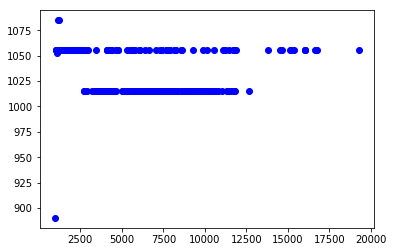

In [48]:
#Decision Tree Regressor
Arvore = DecisionTreeRegressor(random_state = 1)
Arvore.fit(X_treinamento, Y_treinamento)
plt.scatter(Y_teste, Arvore.predict(X_teste), color = 'blue')
plt.show()

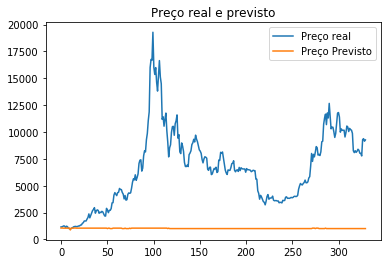

In [49]:
plt.title('Preço real e previsto')
plt.plot(lista,Y_teste, label='Preço real')
plt.plot(lista,y_pred1, label = 'Preço Previsto')
plt.legend()

In [62]:
y_pred1=Arvore.predict(X_teste)
print("R2  =",r2_score(Y_teste, y_pred1))
print("RMS =",rms(Y_teste, y_pred1))

R2  = -2.502845106849257
RMS = 6495.265007215954


## Fazendo o Random Forest Regressor

/Users/omarafrangeneto/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



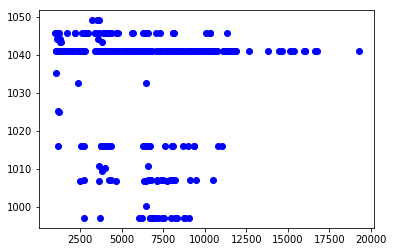

In [51]:
RandomF = RandomForestRegressor(random_state=0)
RandomF.fit(X_treinamento1, Y_treinamento)
plt.scatter(Y_teste, RandomF.predict(X_teste1), color = 'blue')
plt.show()

In [58]:
y_pred2=RandomF.predict(X_teste1)
print("R2  =",r2_score(Y_teste, y_pred2))
print("RMS =",rms(Y_teste, y_pred2))

R2  = -2.496952887123331
RMS = 6489.799787466401


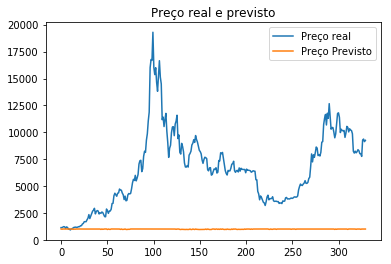

In [53]:
plt.title('Preço real e previsto')
plt.plot(lista,Y_teste, label='Preço real')
plt.plot(lista,y_pred2, label = 'Preço Previsto')
plt.legend()

## Conclusão

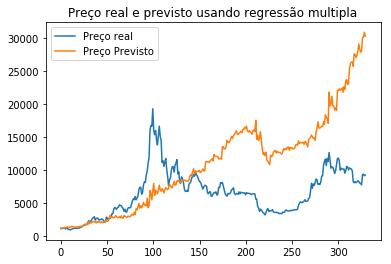

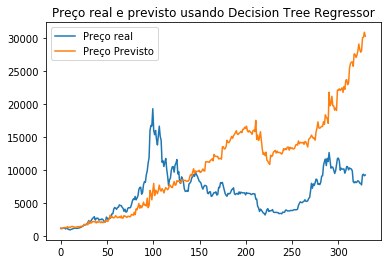

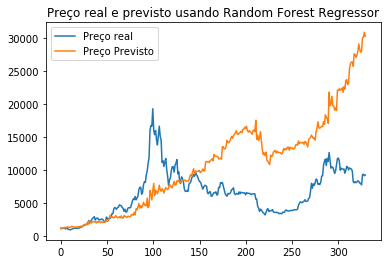

In [54]:
plt.title('Preço real e previsto usando regressão multipla')
plt.plot(lista,Y_teste, label='Preço real')
plt.plot(lista,y_pred, label = 'Preço Previsto')
plt.legend()
plt.show()
plt.title('Preço real e previsto usando Decision Tree Regressor')
plt.plot(lista,Y_teste, label='Preço real')
plt.plot(lista,y_pred, label = 'Preço Previsto')
plt.legend()
plt.show()
plt.title('Preço real e previsto usando Random Forest Regressor')
plt.plot(lista,Y_teste, label='Preço real')
plt.plot(lista,y_pred, label = 'Preço Previsto')
plt.legend()
plt.show()

Como podemos ver o método de previsão que chegou mais perto de prever o preço foi a regressão múltipla. Mesmo assim é possível perceber que todos os modelos são muito falhos e apresentam grande erro ao mostrar a realidade.
Ao nos depara com esse resultado tentamos fazer diversas iteração para tentar melhorar o modelo, porém todas se mostraram falhas.
Após fazer uma análise, concluimos algumas razões que podem explicar os resultados.  
-A dinamica do bitcoin mudou muito de 2014 pra cá, houve uma mudança de cenário e paradigma na cripto economia e, por isso, os dados do passado podem não se aplicar para explicar o presente  
-Por ser um mercado muito especulativo, as variáveis técnicas que dizem respeito a saúde da rede blockchain podem não ter tanta importância no seu valor final  
Pensamos que para próximas iteraões poderíamos fazer uso de um naive-bayes, do mesmo jeito que foi feito no projeto 2, para fazer uma análise sentimental em diversos portais de noticias e fóruns. Dessa forma poderíamos saber o que as pessoas estão achando e a partir disso concluir se o preço do ativo vai cair ou subir